In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df = pd.read_excel('Code Mixed Hindi-English tweets.xlsx')
df.drop(['id'],axis=1, inplace=True)
#pd.set_option('display.max_rows', None)
df

,tweets,labels
0,aaj ka khel khatam hone k baad england cricket...,0
1,purana manjan bech rha hai,5
2,tumhare disappointed se kuch ni hoga,0
3,inse bas tiktok banva lo batting ni hoti isse ...,3
4,bhai cricket par tweets mat kara karo please j...,3
...,...,...
9160,gujarati fraud kyu hotey hai? pnbscam,3
9161,saala idhar 7 lakh k car loan k liye bank choo...,3
9162,mitron nirav modi ji ka relation india k kaun ...,3
9163,or yahn ek month k education loan ki emi pay n...,2


# Labels are as follows:
0 - No emotions,
1 - Happy,
2 - Sad,
3 - Angry,
4 - Fear,
5 - Disgust,
6 - Surprise

In [3]:
print("Dataset shape: ", df.shape)
df['labels'].value_counts()

Dataset shape:  (9165, 2)


0    1892
3    1763
2    1529
1    1226
5    1147
6    1049
4     559
Name: labels, dtype: int64

# Cleaning data:

### Cleaning and removing Punctuations:

In [4]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['tweets'] = df['tweets'].apply(lambda x: cleaning_punctuations(x))

### Cleaning and removing Stopwords:

In [6]:
# Using Hinglish stopwords which contains 1036 words from both English and Hindi languages
# Source: https://github.com/TrigonaMinima/HinglishNLP/blob/master/data/assets/stop_hinglish

stopwordlist = ['a', 'aadi', 'aaj', 'aap', 'aapne', 'aata', 'aati', 'aaya', 'aaye', 'ab', 'abbe', 'abbey', 'abe', 'abhi', 'able', 'about', 'above', 'accha', 'according', 'accordingly', 'acha', 'achcha', 'across', 'actually', 'after', 'afterwards', 'again', 'against', 'agar', 'ain', 'aint', "ain't", 'aisa', 'aise', 'aisi', 'alag', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'andar', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'ap', 'apan', 'apart', 'apna', 'apnaa', 'apne', 'apni', 'appear', 'are', 'aren', 'arent', "aren't", 'around', 'arre', 'as', 'aside', 'ask', 'asking', 'at', 'aur', 'avum', 'aya', 'aye', 'baad', 'baar', 'bad', 'bahut', 'bana', 'banae', 'banai', 'banao', 'banaya', 'banaye', 'banayi', 'banda', 'bande', 'bandi', 'bane', 'bani', 'bas', 'bata', 'batao', 'bc', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'bhai', 'bheetar', 'bhi', 'bhitar', 'bht', 'bilkul', 'bohot', 'bol', 'bola', 'bole', 'boli', 'bolo', 'bolta', 'bolte', 'bolti', 'both', 'brief', 'bro', 'btw', 'but', 'by', 'came', 'can', 'cannot', 'cant', "can't", 'cause', 'causes', 'certain', 'certainly', 'chahiye', 'chaiye', 'chal', 'chalega', 'chhaiye', 'clearly', "c'mon", 'com', 'come', 'comes', 'could', 'couldn', 'couldnt', "couldn't", 'd', 'de', 'dede', 'dega', 'degi', 'dekh', 'dekha', 'dekhe', 'dekhi', 'dekho', 'denge', 'dhang', 'di', 'did', 'didn', 'didnt', "didn't", 'dijiye', 'diya', 'diyaa', 'diye', 'diyo', 'do', 'does', 'doesn', 'doesnt', "doesn't", 'doing', 'done', 'dono', 'dont', "don't", 'doosra', 'doosre', 'down', 'downwards', 'dude', 'dunga', 'dungi', 'during', 'dusra', 'dusre', 'dusri', 'dvaara', 'dvara', 'dwaara', 'dwara', 'each', 'edu', 'eg', 'eight', 'either', 'ek', 'else', 'elsewhere', 'enough', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'far', 'few', 'fifth', 'fir', 'first', 'five', 'followed', 'following', 'follows', 'for', 'forth', 'four', 'from', 'further', 'furthermore', 'gaya', 'gaye', 'gayi', 'get', 'gets', 'getting', 'ghar', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'good', 'got', 'gotten', 'greetings', 'haan', 'had', 'hadd', 'hadn', 'hadnt', "hadn't", 'hai', 'hain', 'hamara', 'hamare', 'hamari', 'hamne', 'han', 'happens', 'har', 'hardly', 'has', 'hasn', 'hasnt', "hasn't", 'have', 'haven', 'havent', "haven't", 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', "here's", 'hereupon', 'hers', 'herself', "he's", 'hi', 'him', 'himself', 'his', 'hither', 'hm', 'hmm', 'ho', 'hoga', 'hoge', 'hogi', 'hona', 'honaa', 'hone', 'honge', 'hongi', 'honi', 'hopefully', 'hota', 'hotaa', 'hote', 'hoti', 'how', 'howbeit', 'however', 'hoyenge', 'hoyengi', 'hu', 'hua', 'hue', 'huh', 'hui', 'hum', 'humein', 'humne', 'hun', 'huye', 'huyi', 'i', "i'd", 'idk', 'ie', 'if', "i'll", "i'm", 'imo', 'in', 'inasmuch', 'inc', 'inhe', 'inhi', 'inho', 'inka', 'inkaa', 'inke', 'inki', 'inn', 'inner', 'inse', 'insofar', 'into', 'inward', 'is', 'ise', 'isi', 'iska', 'iskaa', 'iske', 'iski', 'isme', 'isn', 'isne', 'isnt', "isn't", 'iss', 'isse', 'issi', 'isski', 'it', "it'd", "it'll", 'itna', 'itne', 'itni', 'itno', 'its', "it's", 'itself', 'ityaadi', 'ityadi', "i've", 'ja', 'jaa', 'jab', 'jabh', 'jaha', 'jahaan', 'jahan', 'jaisa', 'jaise', 'jaisi', 'jata', 'jayega', 'jidhar', 'jin', 'jinhe', 'jinhi', 'jinho', 'jinhone', 'jinka', 'jinke', 'jinki', 'jinn', 'jis', 'jise', 'jiska', 'jiske', 'jiski', 'jisme', 'jiss', 'jisse', 'jitna', 'jitne', 'jitni', 'jo', 'just', 'jyaada', 'jyada', 'k', 'ka', 'kaafi', 'kab', 'kabhi', 'kafi', 'kaha', 'kahaa', 'kahaan', 'kahan', 'kahi', 'kahin', 'kahte', 'kaisa', 'kaise', 'kaisi', 'kal', 'kam', 'kar', 'kara', 'kare', 'karega', 'karegi', 'karen', 'karenge', 'kari', 'karke', 'karna', 'karne', 'karni', 'karo', 'karta', 'karte', 'karti', 'karu', 'karun', 'karunga', 'karungi', 'kaun', 'kaunsa', 'kayi', 'kch', 'ke', 'keep', 'keeps', 'keh', 'kehte', 'kept', 'khud', 'ki', 'kin', 'kine', 'kinhe', 'kinho', 'kinka', 'kinke', 'kinki', 'kinko', 'kinn', 'kino', 'kis', 'kise', 'kisi', 'kiska', 'kiske', 'kiski', 'kisko', 'kisliye', 'kisne', 'kitna', 'kitne', 'kitni', 'kitno', 'kiya', 'kiye', 'know', 'known', 'knows', 'ko', 'koi', 'kon', 'konsa', 'koyi', 'krna', 'krne', 'kuch', 'kuchch', 'kuchh', 'kul', 'kull', 'kya', 'kyaa', 'kyu', 'kyuki', 'kyun', 'kyunki', 'lagta', 'lagte', 'lagti', 'last', 'lately', 'later', 'le', 'least', 'lekar', 'lekin', 'less', 'lest', 'let', "let's", 'li', 'like', 'liked', 'likely', 'little', 'liya', 'liye', 'll', 'lo', 'log', 'logon', 'lol', 'look', 'looking', 'looks', 'ltd', 'lunga', 'm', 'maan', 'maana', 'maane', 'maani', 'maano', 'magar', 'mai', 'main', 'maine', 'mainly', 'mana', 'mane', 'mani', 'mano', 'many', 'mat', 'may', 'maybe', 'me', 'mean', 'meanwhile', 'mein', 'mera', 'mere', 'merely', 'meri', 'might', 'mightn', 'mightnt', "mightn't", 'mil', 'mjhe', 'more', 'moreover', 'most', 'mostly', 'much', 'mujhe', 'must', 'mustn', 'mustnt', "mustn't", 'my', 'myself', 'na', 'naa', 'naah', 'nahi', 'nahin', 'nai', 'name', 'namely', 'nd', 'ne', 'near', 'nearly', 'necessary', 'neeche', 'need', 'needn', 'neednt', "needn't", 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nhi', 'nine', 'no', 'nobody', 'non', 'none', 'noone', 'nope', 'nor', 'normally', 'not', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own', 'par', 'pata', 'pe', 'pehla', 'pehle', 'pehli', 'people', 'per', 'perhaps', 'phla', 'phle', 'phli', 'placed', 'please', 'plus', 'poora', 'poori', 'provides', 'pura', 'puri', 'q', 'que', 'quite', 'raha', 'rahaa', 'rahe', 'rahi', 'rakh', 'rakha', 'rakhe', 'rakhen', 'rakhi', 'rakho', 'rather', 're', 'really', 'reasonably', 'regarding', 'regardless', 'regards', 'rehte', 'rha', 'rhaa', 'rhe', 'rhi', 'ri', 'right', 's', 'sa', 'saara', 'saare', 'saath', 'sab', 'sabhi', 'sabse', 'sahi', 'said', 'sakta', 'saktaa', 'sakte', 'sakti', 'same', 'sang', 'sara', 'sath', 'saw', 'say', 'saying', 'says', 'se', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven', 'several', 'shall', 'shan', 'shant', "shan't", 'she', "she's", 'should', 'shouldn', 'shouldnt', "shouldn't", "should've", 'si', 'since', 'six', 'so', 'soch', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'still', 'sub', 'such', 'sup', 'sure', 't', 'tab', 'tabh', 'tak', 'take', 'taken', 'tarah', 'teen', 'teeno', 'teesra', 'teesre', 'teesri', 'tell', 'tends', 'tera', 'tere', 'teri', 'th', 'tha', 'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats', "that's", 'the', 'theek', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'theres', "there's", 'thereupon', 'these', 'they', "they'd", "they'll", "they're", "they've", 'thi', 'thik', 'thing', 'think', 'thinking', 'third', 'this', 'tho', 'thoda', 'thodi', 'thorough', 'thoroughly', 'those', 'though', 'thought', 'three', 'through', 'throughout', 'thru', 'thus', 'tjhe', 'to', 'together', 'toh', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'true', 'truly', 'try', 'trying', 'tu', 'tujhe', 'tum', 'tumhara', 'tumhare', 'tumhari', 'tune', 'twice', 'two', 'um', 'umm', 'un', 'under', 'unhe', 'unhi', 'unho', 'unhone', 'unka', 'unkaa', 'unke', 'unki', 'unko', 'unless', 'unlikely', 'unn', 'unse', 'until', 'unto', 'up', 'upar', 'upon', 'us', 'use', 'used', 'useful', 'uses', 'usi', 'using', 'uska', 'uske', 'usne', 'uss', 'usse', 'ussi', 'usually', 'vaala', 'vaale', 'vaali', 'vahaan', 'vahan', 'vahi', 'vahin', 'vaisa', 'vaise', 'vaisi', 'vala', 'vale', 'vali', 'various', 've', 'very', 'via', 'viz', 'vo', 'waala', 'waale', 'waali', 'wagaira', 'wagairah', 'wagerah', 'waha', 'wahaan', 'wahan', 'wahi', 'wahin', 'waisa', 'waise', 'waisi', 'wala', 'wale', 'wali', 'want', 'wants', 'was', 'wasn', 'wasnt', "wasn't", 'way', 'we', "we'd", 'well', "we'll", 'went', 'were', "we're", 'weren', 'werent', "weren't", "we've", 'what', 'whatever', "what's", 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', "where's", 'whereupon', 'wherever', 'whether', 'which', 'while', 'who', 'whoever', 'whole', 'whom', "who's", 'whose', 'why', 'will', 'willing', 'with', 'within', 'without', 'wo', 'woh', 'wohi', 'won', 'wont', "won't", 'would', 'wouldn', 'wouldnt', "wouldn't", 'y', 'ya', 'yadi', 'yah', 'yaha', 'yahaan', 'yahan', 'yahi', 'yahin', 'ye', 'yeah', 'yeh', 'yehi', 'yes', 'yet', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've", 'yup']

In [7]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['tweets'] = df['tweets'].apply(lambda text: cleaning_stopwords(text))

### Cleaning and removing Numeric numbers:

In [8]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['tweets'] = df['tweets'].apply(lambda text: cleaning_numbers(text))

In [9]:
# Splitting data into Train and Test sets
X = df['tweets']
y = df['labels']
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 3)

# Transforming Dataset using TF-IDF Vectorizer

### Fitting the TF-IDF Vectorizer

In [10]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  81160


### Transforming the data using TF-IDF Vectorizer

In [11]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

## Building Models:

## 1. SVC:

In [12]:
kernels = ['rbf','linear','poly','sigmoid']

svc = SVC()
hyperParam = {'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf','linear','poly','sigmoid']}

gsv = GridSearchCV(svc,hyperParam,cv=5,verbose=1)
best_model = gsv.fit(X_train, y_train)                        # Fitting model with X_train and y_train
svc_pred = best_model.predict(X_test)                         # Predicting the results

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy :",best_model.score(X_test, y_test))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best HyperParameter:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Accuracy : 0.7375886524822695


              precision    recall  f1-score   support

           0       0.58      0.87      0.70       361
           1       0.79      0.70      0.74       242
           2       0.77      0.73      0.75       310
           3       0.74      0.73      0.73       346
           4       0.89      0.70      0.78       104
           5       0.90      0.75      0.82       239
           6       0.88      0.59      0.71       231

    accuracy                           0.74      1833
   macro avg       0.79      0.73      0.75      1833
weighted avg       0.77      0.74      0.74      1833



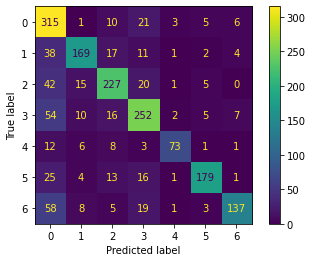

In [13]:
print(metrics.classification_report(y_test, svc_pred))
plot_confusion_matrix(gsv, X_test, y_test)

## 2. Multinomial Naive Bayes:

In [14]:
clf_alpha = [0, 0.1, 0.2, 0.5, 0.7, 0.9, 1, 1.1, 1.3, 1.5]
f_prior = [True, False]

nb_clf = MultinomialNB()
hyperParam = {'alpha':clf_alpha,'fit_prior' : f_prior}

gsv = GridSearchCV(nb_clf,hyperParam,cv=5,verbose=1,n_jobs=-1)
best_model = gsv.fit(X_train, y_train)                         # Fitting model with X_train and y_train
nb_clf_pred = best_model.predict(X_test)                       # Predicting the results

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy :",best_model.score(X_test, y_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best HyperParameter:  {'alpha': 1.5, 'fit_prior': False}
Best Accuracy : 0.6830332787779596


              precision    recall  f1-score   support

           0       0.58      0.78      0.66       361
           1       0.89      0.55      0.68       242
           2       0.67      0.69      0.68       310
           3       0.56      0.83      0.67       346
           4       0.90      0.63      0.75       104
           5       0.92      0.60      0.73       239
           6       0.93      0.55      0.69       231

    accuracy                           0.68      1833
   macro avg       0.78      0.66      0.69      1833
weighted avg       0.74      0.68      0.69      1833



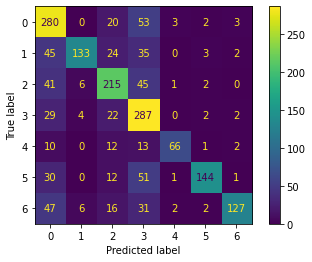

In [15]:
print(metrics.classification_report(y_test, nb_clf_pred))
plot_confusion_matrix(gsv, X_test, y_test)

## 3. Logistic Regression:

In [16]:
c_val = [0.001,0.01,0.1,0.5,1.0]

logreg = LogisticRegression(multi_class='multinomial')
hyperParam = [{'C':c_val}]

gsv = GridSearchCV(logreg,hyperParam,cv=5,verbose=1)
best_model = gsv.fit(X_train, y_train)                         # Fitting model with X_train and y_train
logreg_pred = best_model.predict(X_test)                       # Predicting the results

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy :",best_model.score(X_test, y_test))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best HyperParameter:  {'C': 1.0}
Best Accuracy : 0.7288597926895799


              precision    recall  f1-score   support

           0       0.53      0.92      0.68       361
           1       0.86      0.66      0.75       242
           2       0.75      0.72      0.74       310
           3       0.75      0.71      0.73       346
           4       0.92      0.66      0.77       104
           5       0.93      0.73      0.82       239
           6       0.93      0.58      0.72       231

    accuracy                           0.73      1833
   macro avg       0.81      0.71      0.74      1833
weighted avg       0.78      0.73      0.73      1833



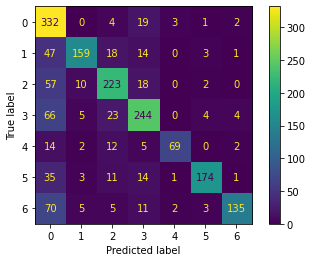

In [17]:
print(metrics.classification_report(y_test, logreg_pred))
plot_confusion_matrix(gsv, X_test, y_test)

## 4. Random Forest:

In [18]:
rf = RandomForestClassifier()
hyperParam = [{'n_estimators' : [1, 5, 10, 20, 50, 100]}]

gsv = GridSearchCV(rf,hyperParam,cv=5,verbose=1)
best_model = gsv.fit(X_train, y_train)                        # Fitting model with X_train and y_train
rf_pred = best_model.predict(X_test)                          # Predicting the results

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy :",best_model.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best HyperParameter:  {'n_estimators': 100}
Best Accuracy : 0.7266775777414075


              precision    recall  f1-score   support

           0       0.60      0.84      0.70       361
           1       0.70      0.69      0.70       242
           2       0.76      0.69      0.72       310
           3       0.80      0.67      0.73       346
           4       0.94      0.70      0.80       104
           5       0.95      0.73      0.82       239
           6       0.67      0.73      0.70       231

    accuracy                           0.73      1833
   macro avg       0.77      0.72      0.74      1833
weighted avg       0.75      0.73      0.73      1833



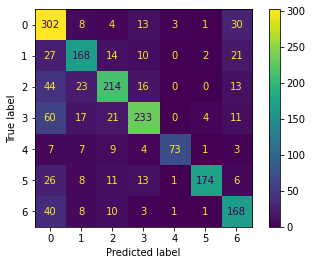

In [19]:
print(metrics.classification_report(y_test, rf_pred))
plot_confusion_matrix(gsv, X_test, y_test)